<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Complex CNN Architectures

---
## Problem Statement

Osborne Research Labs is a recently started research lab. Our lab is conducting research on computer vision systems for drones and robotics. Given we are just entering the field and we have a basic understanding of convolutional neural networks (CNNs), we wanted to research popular complex CNN architecures. The goal of this project is to learn about the pros and cons of three popular CNN architecures and see how they perform on an indoor scene data set. We're hoping for accuracy scores above the baseline of 9%. 

---

In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# check for GPU connection
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.6.0
Found GPU at: /device:GPU:0


In [4]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, concatenate, Input, AveragePooling2D, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)
np.random.seed(42)

In [5]:
# Create Train, Test and Validation sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/Colab Notebooks/classification-capstone/data/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/classification-capstone/data/test'
img_width = 224
img_height = 224


train_gen = train_datagen.flow_from_directory(
   train_dir,
   target_size=(img_height, img_width),
   batch_size=128,
   class_mode='categorical',
   subset='training',
   seed=42 
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=128,
    class_mode='categorical',
    seed=42
)

Found 5441 images belonging to 11 classes.
Found 1355 images belonging to 11 classes.
Found 220 images belonging to 11 classes.


In [ ]:
# number of steps per epoch for training
train_steps = train_gen.samples // train_gen.batch_size
val_steps = validation_gen.samples // validation_gen.batch_size
print(train_steps)
print(val_steps)

42
10


In [ ]:
# Inception Module architecture
def inception(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None): 
  '''
  Arguments:
  X -- tensor input
  filters_1x1 -- integer, number of filters for 1x1 layer
  filter_3x3_reduce -- integer, number of filters for 3x3 reduction layer
  filters_3x3 -- integer, number of filters for 3x3 layer
  filter_5x5_reduce -- integer, number of filters for 5x5 reduction layer
  filters_5x5 -- integer, number of filters for 5x5 layer
  filters_pool_proj -- integer, number of filters for 1x1 layer after pooling layer
  '''
  # 1 x 1 route
  conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
  
  # 3 x 3 route = 1 x 1 conv + 3 x 3 conv
  conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

  # 5 x 5 route = 1 x 1 conv + 5 x 5 conv
  conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

  # pool route = Pool + 1 x 1 conv
  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
  pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

  output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

  return output

In [ ]:
# GoogLeNet Model Implementation
# input layer
input_layer = Input(shape=(224, 224, 3))

# part a
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input_layer)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

# part b

# inception module 3
x = inception(x, 
              filters_1x1=64, 
              filters_3x3_reduce=96, 
              filters_3x3=128, 
              filters_5x5_reduce=16, 
              filters_5x5=32, 
              filters_pool_proj=32,
              name='inception_3a')
x = inception(x, 
              filters_1x1=128, 
              filters_3x3_reduce=128, 
              filters_3x3=192, 
              filters_5x5_reduce=32, 
              filters_5x5=96, 
              filters_pool_proj=64,
              name='inception_3b')
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2))(x)

# inception module 4
x = inception(x, 
              filters_1x1=192, 
              filters_3x3_reduce=96, 
              filters_3x3=208, 
              filters_5x5_reduce=16, 
              filters_5x5=48, 
              filters_pool_proj=64,
              name='inception_4a')
x = inception(x, 
              filters_1x1=160, 
              filters_3x3_reduce=112, 
              filters_3x3=224, 
              filters_5x5_reduce=24, 
              filters_5x5=64, 
              filters_pool_proj=64,
              name='inception_4b')
x = inception(x, 
              filters_1x1=128, 
              filters_3x3_reduce=128, 
              filters_3x3=256, 
              filters_5x5_reduce=24, 
              filters_5x5=64, 
              filters_pool_proj=64,
              name='inception_4c')
x = inception(x, 
              filters_1x1=112, 
              filters_3x3_reduce=144, 
              filters_3x3=288, 
              filters_5x5_reduce=32, 
              filters_5x5=64, 
              filters_pool_proj=64,
              name='inception_4d')
x = inception(x, 
              filters_1x1=256, 
              filters_3x3_reduce=160, 
              filters_3x3=320, 
              filters_5x5_reduce=32, 
              filters_5x5=128, 
              filters_pool_proj=128,
              name='inception_4e')
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

# inception module 5
x = inception(x, 
              filters_1x1=256, 
              filters_3x3_reduce=160, 
              filters_3x3=320, 
              filters_5x5_reduce=32, 
              filters_5x5=128, 
              filters_pool_proj=128,
              name='inception_5a')
x = inception(x, 
              filters_1x1=384, 
              filters_3x3_reduce=192, 
              filters_3x3=384, 
              filters_5x5_reduce=48, 
              filters_5x5=128, 
              filters_pool_proj=128,
              name='inception_5b')

# part c
x = AveragePooling2D(pool_size=(7, 7), strides=1, padding='valid')(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(11, activation='relu', name='linear')(x)
x = Dense(11, activation='softmax', name='output')(x)

model = Model(input_layer, outputs = x, name='googlenet')

model.summary()

Model: "googlenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pool_1_3x3/2[0][0]           
__________________________________________________________________________________________

In [ ]:
# reduce the learning rate by a factor of 10 when val loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.10), patience=5, verbose=1)

In [ ]:
# NOTE - Original paper uses SGD optimizer w/ learning rate 0.01 and a momentum of 0.9
optimizer = Adam(learning_rate=0.01)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 10)

In [ ]:
# Saves the best model during training
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/classification-capstone/models/googlenet.h5',
                               verbose=1,
                               save_best_only=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall()])

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_gen, 
      validation_data=validation_gen,
      epochs=100, 
      verbose=1,
      steps_per_epoch=train_steps,
      validation_steps=val_steps,
      callbacks=[checkpointer, reduce_lr, early_stop])

Epoch 1/100
42/42 [==============================] - 51s 1s/step - loss: 6015.0386 - accuracy: 0.1018 - precision: 0.0776 - recall: 0.0034 - val_loss: 2.3961 - val_accuracy: 0.1031 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 2.39610, saving model to /content/drive/MyDrive/Colab Notebooks/classification-capstone/models/googlenet.h5
Epoch 2/100
42/42 [==============================] - 41s 988ms/step - loss: 988.3489 - accuracy: 0.1030 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3927 - val_accuracy: 0.1031 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_loss improved from 2.39610 to 2.39273, saving model to /content/drive/MyDrive/Colab Notebooks/classification-capstone/models/googlenet.h5
Epoch 3/100
42/42 [==============================] - 42s 996ms/step - loss: 2.3925 - accuracy: 0.1045 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3906 - val_accuracy: 0.1055 - val_precision: 0.0000e+

In [ ]:
# store accuracy, precision, loss, and recall values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision']
val_prec = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

epochs_range = range(len(history.epoch))


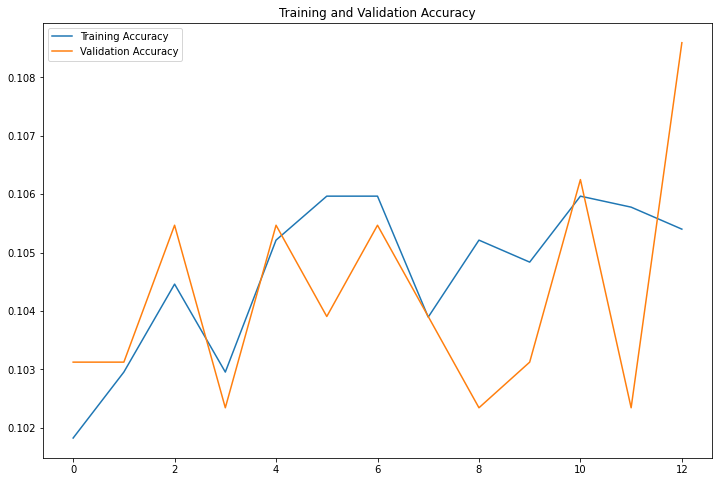

In [ ]:
# plot training and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

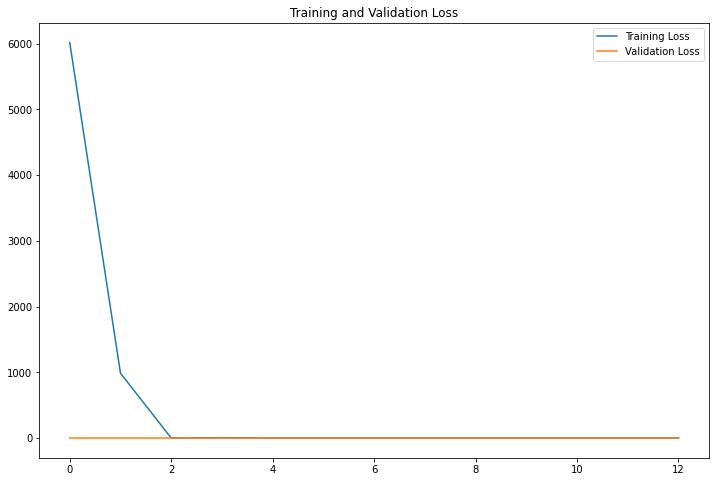

In [ ]:
# plot training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend();

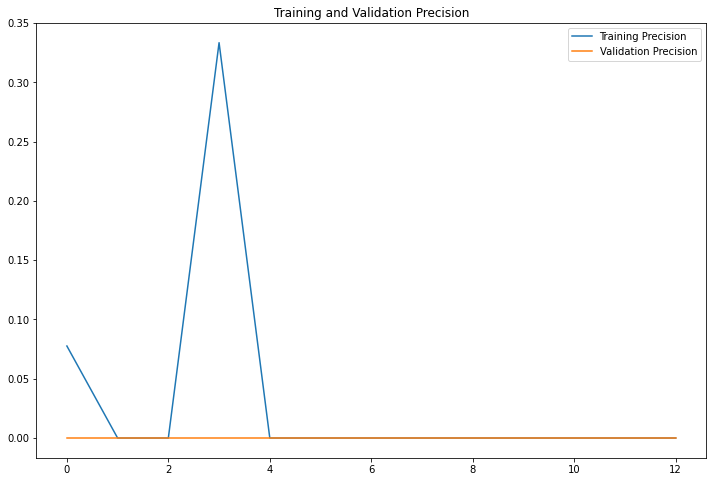

In [ ]:
# plot training and validation Precision
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend();

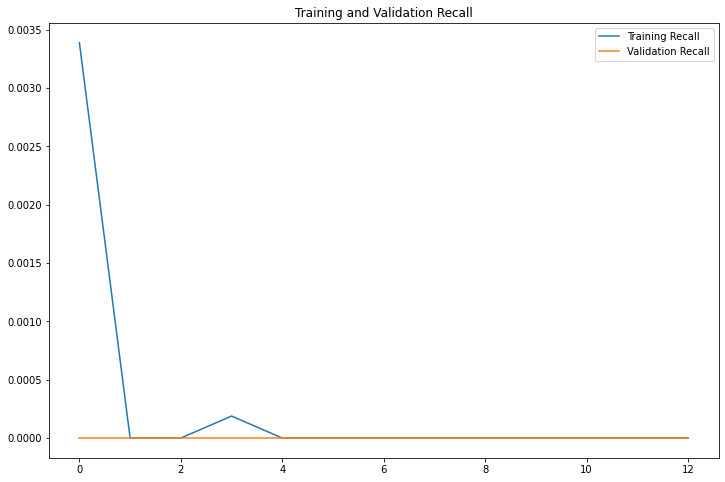

In [ ]:
# plot training and validation recall
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend();

Looking at all the plots the GoogleNet architecure is not performing well on this indoor data set. Top accuracy is around 10%. Although the chart is showing that the loss is reaching zero for both the train and validation set, the model is clearly not learning enough of the data. Precision and recall are very low. Possibly may need more data to increase learning.

In [6]:
# load googlenet model
googleNet = load_model('/content/drive/MyDrive/Colab Notebooks/classification-capstone/models/googlenet.h5')

In [7]:
# load gym image for quick test of predictions
img_path = '/content/drive/MyDrive/Colab Notebooks/classification-capstone/data/other photos/humphrey-muleba-dDp-6pXrYik-unsplash.jpg'
img = load_img(img_path, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 224, 224, 3)


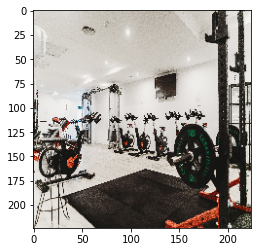

In [9]:
# display image of gym
plt.imshow(img_tensor[0])
plt.show();

In [10]:
# Extract the outputs of the top 8 layers
layer_outputs = [layer.output for layer in googleNet.layers[:8]]
# creates a model that will return the  outputs for the given model inputs
activation_model = Model(inputs=googleNet.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

In [11]:
# Activation of the 3rd convolutional layer for gym image
first_layer_activation = activations[4]
print(first_layer_activation.shape)

(1, 56, 56, 64)


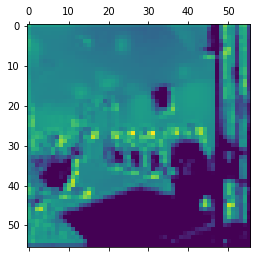

In [12]:
# visualize the 4th channel of the activation of the 3rd layer 
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

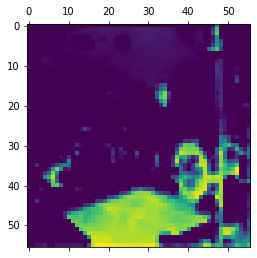

In [13]:
# visualize the 7th channel of the activation of the 3rd layer 
plt.matshow(first_layer_activation[0, :, :, 6], cmap='viridis')

In [15]:
# Display activations across all channels for all layers
layer_names = []
for layer in googleNet.layers[:]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  
  size = layer_activation.shape[1]

  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Output hidden; open in https://colab.research.google.com to view.

Looking at the activations it looks like the model is picking up a lot of details in the image. It looks like it's struggling to pick out finer details like edges, especially in lower levels of the network.

In [16]:
# get list of classes for model
labels = list(train_gen.class_indices.keys())

In [17]:
# test prediction on gym image
preds = googleNet.predict(img_tensor)

In [18]:
# display predictions in a data frame
pd.DataFrame(preds, columns=[labels])

,bathroom,bedroom,closet,corridor,elevator,gym,kitchen,livingroom,office,pantry,stairscase
0,0.10575,0.095975,0.081576,0.098131,0.080436,0.085015,0.10327,0.097458,0.080655,0.089831,0.081901


In [20]:
# model predictions on test images
preds = googleNet.predict(test_gen)
reshaped_preds = preds.reshape(1, -1)[0].round()

In [21]:
# create list of mistakes
mistakes = [(file, pred, y) for file, pred, y in zip(test_gen.filenames, reshaped_preds, test_gen.labels) if pred != y]
len(mistakes)

200

In [22]:
# look at the first 100 mistakes
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
k = 0
for i in range(10):
  for j in range(10):
    ax[i, j].imshow(plt.imread(f'/content/drive/MyDrive/Colab Notebooks/classification-capstone/data/test/{mistakes[k][0]}'))
    k += 1
    
    if k == len(mistakes):
      break

Output hidden; open in https://colab.research.google.com to view.

In [23]:
# create list of correct predictions
correct = [(file, pred, y) for file, pred, y in zip(test_gen.filenames, reshaped_preds, test_gen.labels) if pred == y]
len(correct)

20

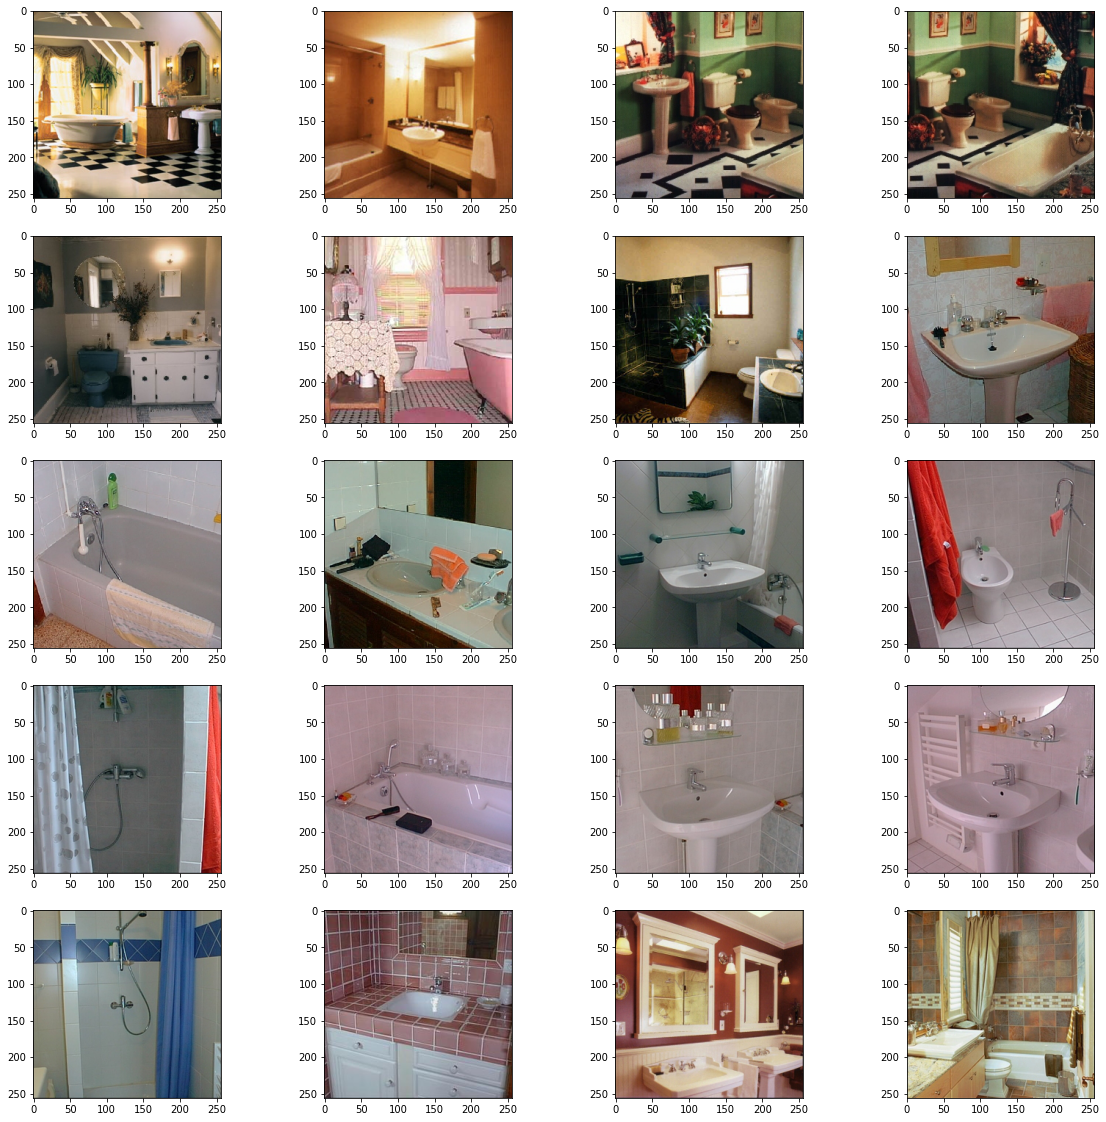

In [24]:
# look at images that were correctly identified
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
k = 0
for i in range(5):
  for j in range(4):
    ax[i, j].imshow(plt.imread(f'/content/drive/MyDrive/Colab Notebooks/classification-capstone/data/test/{correct[k][0]}'))
    k += 1
    
    if k == len(correct):
      break

Did really well predicting all 20 bathroom images.